In [4]:
import torch
import math
import matplotlib.pyplot as plt
from torch import nn
import numpy as np
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [37]:
class BC_1D:
    def __init__(self, left, right):
        """
        Args:
            left, right: (alpha, beta, f(t))
        """
        self.left_alpha, self.left_beta, self.left_func = left
        self.right_alpha, self.right_beta, self.right_func = right
        
    def apply(self, grid, dx, cur_time):
        gamma_left = self.left_beta / dx
        gamma_right = self.right_beta / dx
        
        # Left boundary
        grid[0] = (self.left_func(cur_time) - gamma_left * grid[1]) / (self.left_alpha - gamma_left)
 
        # Right boundary (fixed typo)
        grid[-1] = (self.right_func(cur_time) + gamma_right * grid[-2]) / (self.right_alpha + gamma_right)

        
class Heat1dSimu:
    def __init__(self, L, xstep, total_time, tstep, bc, ic, c, plot_step, device='cpu'):
        """
        Args:
            L (float): Physical length of the 1D domain.
            xstep (int): Number of *interior* points (excluding boundaries).
            total_time (float): End time for the simulation.
            tstep (int): Number of time steps to take.
            bc (BC_1D): Boundary condition (beta, f(t)).
            ic (callable): Function for initial condition.
            c (float): Diffusion coefficient.
            plot_step (int): How often (in steps) to plot the solution.
            device (str): 'cpu' or 'cuda', which device to use for Tensor operations.
        """
        self.L = L
        self.xstep = xstep
        self.total_time = total_time
        self.tstep = tstep
        self.bc = bc
        self.ic = ic
        self.c = c
        self.device = device
        self.cur_time = 0.0
        self.plot_step = plot_step

        # Discretization
        self.dx = L / (xstep + 1)
        self.dt = total_time / tstep
        self.c_dt_dx2 = c * self.dt / (self.dx ** 2)  # Precompute factor

        # Solution array (including boundary points)
        self.grid = torch.zeros(xstep + 2, device=device)

        # Set initial condition
        self.set_ic()

        # Define convolution kernel once
        self.conv = nn.Conv1d(1, 1, kernel_size=3, bias=False, device=device)
        with torch.no_grad():
            self.conv.weight[:] = self.c_dt_dx2 * torch.tensor(
                [[[1, -2, 1]]], dtype=torch.float, device=device
            )

    def set_bc(self):
        """Apply boundary conditions using the stored current time."""
        self.bc.apply(self.grid, self.dx, self.cur_time)

    def set_ic(self):
        """Initialize interior points using the function `ic`."""
        x_interior = torch.linspace(self.dx, self.dx * self.xstep, self.xstep, device=self.device)
        self.grid[1:-1] = self.ic(x_interior)

    def update(self):
        """Perform one step of the explicit finite difference update."""
        self.set_bc()  # Apply boundary conditions

        with torch.no_grad():  # Prevent autograd tracking
            input_for_conv = self.grid.view(1, 1, -1)
            second_diff = self.conv(input_for_conv).view(-1)
            self.grid[1:-1] += second_diff  # Update interior points

        self.cur_time += self.dt

    def start(self, do_plot=True):
        """Run the time-stepping simulation and (optionally) plot."""
        if do_plot:
            fig, ax = plt.subplots(figsize=(8, 5))
            
            # Create a colormap & normalization for time
            cmap = plt.cm.plasma
            norm = plt.Normalize(vmin=0, vmax=self.total_time)

            # Prepare a ScalarMappable just for the colorbar scale
            sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])

        for step in tqdm(range(self.tstep)):
            self.update()

            if do_plot and step % self.plot_step == 0:
                current_time = step * self.dt
                color = cmap(norm(current_time))

                # Plot on the specified axes
                ax.plot(
                    self.grid.cpu().numpy(),
                    color=color,
                    label=f't={current_time:.2f}'
                )

        if do_plot:
            # Create the colorbar using the figure, pointing to the same axes
            cbar = fig.colorbar(sm, ax=ax, label='Time')
            ax.set_xlabel("Grid Index")
            ax.set_ylabel("Temperature")
            ax.set_title("1D Heat Equation Evolution")
            ax.grid(True)
            plt.show()


In [42]:
def ic(x):
    return torch.cos(x)

def left(t):
    return 0

def right(t):
    return 0

bc = BC_1D((0,1,left), (0,1,right)) 
L = math.pi
xstep = 500
total_time = 0.5
tstep = 80000
c = 1
factor = c * total_time / tstep /(L / (xstep + 1))**2
plot_step = 8000
print(factor)

0.15894824009631517


100%|██████████| 80000/80000 [00:10<00:00, 7762.25it/s]


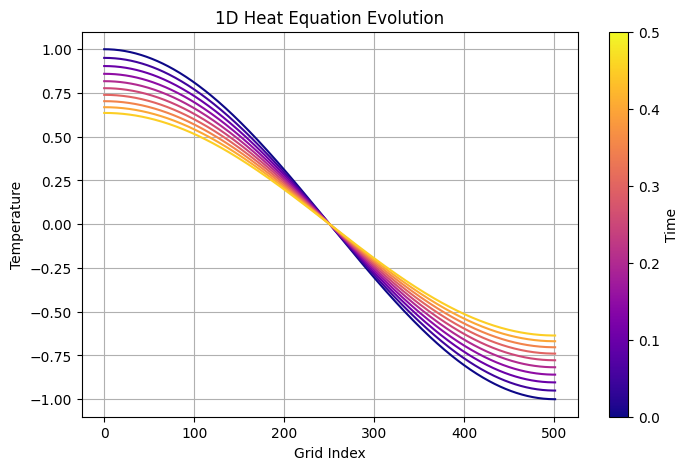

In [43]:
test = Heat1dSimu(L, xstep, total_time, tstep, bc, ic, c, plot_step, 'cuda')
test.start()




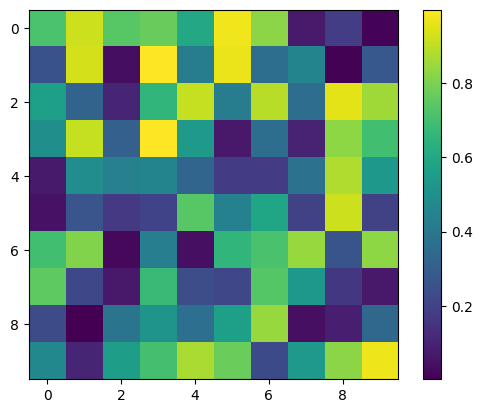

In [102]:
import matplotlib.pyplot as plt
import numpy as np

# Create data
x = np.random.rand(10, 10)

# Create figure and axis
fig, ax = plt.subplots()

# Create heatmap with color mapping
cax = ax.imshow(x, cmap='viridis')

# Add color bar
fig.colorbar(cax)

# Show plot
plt.show()
